In [1]:
import numpy as np
import cvxopt as cvx
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
from numpy import log,exp
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (10, 6)

### Let us generate some data:

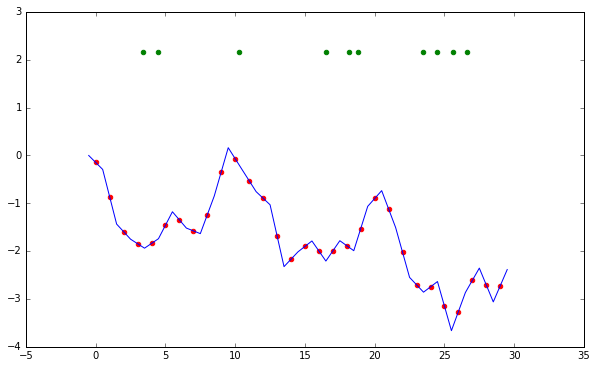

In [2]:
np.random.seed(420) #makes data reproducible

Ides = 0.1
pmax = 2.
N = 30
M = 10
slope = 0.6

xxx = [-0.5]
yyy = [0.]
x = []
y = []
for i in range(N):
    s = np.random.randn()
    yyy.append(yyy[-1]+slope * s)
    xxx.append(xxx[-1]+1.)
    x.append(0.5*(xxx[-1]+xxx[-2]))
    y.append(0.5*(yyy[-1]+yyy[-2]))
    
ymax = max(yyy)    

ylamps = [ymax +2.] * M
xlamps = sorted(np.random.rand(M)*N)

plt.plot(xxx,yyy)
plt.scatter(x,y,color = 'red')
plt.scatter(xlamps,ylamps, color = 'green')

The blue profile is a collection of $N=30$ patches. The green dots above are lamps. The goal of this exercize is to set the power of each lamp, in order to obtain an intensity *as uniform as possible* on all patches. The quantity of interest is in fact $\log I$. We propose to minimize
$$\max_{k=1,\ldots,N}\ | \log I_k - \log I_{des} | ,$$
subject to the constraint that the power of each lamp must be in the interval $[0,p_{max}]$.

Physics tell us that the intesity on the $i$th patch is given by
$ I_i = \sum_{j=1}^M A_{i,j}\, p_j$,
where $p_j$ is the power of the $j$th lamp and
$$A_{i,j} = \left\{\begin{array}{cl}
                    \frac{1}{(r_{i,j})^2} \cos \theta_{i,j} & \textrm{if patch $i$ receives light from lamp $j$}\\
                    0 & \textrm{otherwise.}
                    \end{array} \right.                    
$$
In this formula, $r_{i,j}$ denotes the distance from patch $i$ to lamp $j$, and $\theta_{i,j}$ is the illumination angle.

--

### Computation of Matrix $A$

In [3]:
#r[i,j] is the distance from lamp j to patch i
r = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        r[i,j] = np.linalg.norm([x[i]-xlamps[j],y[i]-ylamps[j]])


#theta[i,j] is illumination angle from lamp j to patch i
costheta = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        #index of xxx_k's between xi and xlamp_j
        index_x_between = [k for k in range(N+1) if np.sign((xxx[k]-x[i])*(xxx[k]-xlamps[j])) == -1]
        y_patch = [yyy[k] for k in index_x_between]
        y_line_from_lamp = [ymax +2. + (xxx[k]-xlamps[j]) * (y[i]-ymax-2.)/(x[i]-xlamps[j]) for k in index_x_between]

        if any([y2<=y1 for y1,y2 in zip(y_patch,y_line_from_lamp)]):
            #this patch gets no line from this lamp (it is hidden by some other patch)
            costheta[i,j] = 0.
        else:
            dy = yyy[i+1]-yyy[i]
            normal_dir = np.array([-dy,1.])
            normal_dir /= np.linalg.norm(normal_dir)
            lamp_dir = np.array([xlamps[j]-x[i],ylamps[j]-y[i]])
            costheta[i,j] = (normal_dir.dot(lamp_dir))/np.linalg.norm(lamp_dir)
            
assert np.min(costheta)>=0.
assert np.min(costheta)<=1.

A = cvx.matrix(0.,(N,M))
for i in range(N):
    for j in range(M):
        A[i,j] = 1./r[i,j]**2 * costheta[i,j]

### short function to visualize a solution

In [4]:
def visualize_sol(pp,normalized=False):
    colors = (np.log(A*pp)-np.log(Ides)).ravel()
    if normalized:
        mm,MM = -1.2,1.2
    else:
        mm,MM = min(colors),max(colors)
    logdifs = np.array(colors)
    colors -= mm
    colors /= (MM-mm)
    
    for i in range(N):
        plt.plot([xxx[i],xxx[i+1]],[yyy[i],yyy[i+1]],color = matplotlib.cm.jet(colors[i]),linewidth=2)
    fg = plt.scatter(x,y,c=logdifs)
    plt.scatter(xlamps,ylamps, s=20*pp)
    cbar = plt.colorbar(fg)
    yt = cbar.ax.get_yticks()
    cbar.ax.set_yticklabels(['Ides * {0:.2f}'.format(yi) if yi>=1 else 'Ides / {0:.2f}'.format(1./yi) for yi in exp((MM-mm)*yt+mm)])
    
    II = A*pp
    print 'des. Intensity: '+str(Ides)
    print 'min  Intensity: '+str(min(II))
    print 'max  Intensity: '+str(max(II))
    print 'ratio Imax/Ides:'+str(max(II)/Ides)
    print 'ratio Ides/Imin:'+str(Ides/min(II))
    

Let us now visualize the solution with all lamps on, with a power p=1:

[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]

des. Intensity: 0.1
min  Intensity: 0.0545211480435
max  Intensity: 0.2531736417
ratio Imax/Ides:2.531736417
ratio Ides/Imin:1.83415066609


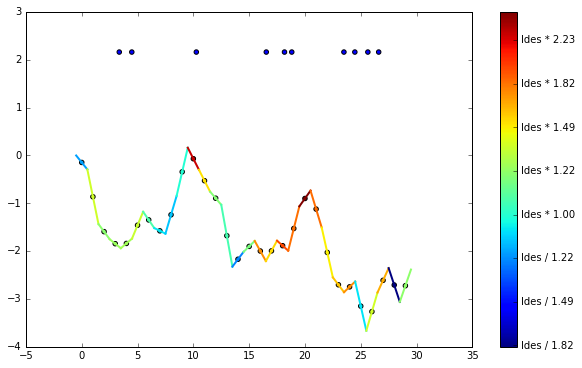

In [5]:
p_unit = cvx.matrix([1.]*M)
print p_unit
visualize_sol(p_unit)

### Rounded Least-square approximation

In [6]:
import picos as pic
P = pic.Problem()
p = P.add_variable('p',M)
P.minimize(pic.norm(A*p-Ides)**2,verbose=False)
p_sol = p.value
p_rlsq = cvx.matrix([min(max(pi,0),pmax) for pi in p_sol])

Now, let's visualize the solution !

des. Intensity: 0.1
min  Intensity: 0.0659557148978
max  Intensity: 0.29564564139
ratio Imax/Ides:2.9564564139
ratio Ides/Imin:1.51616884382


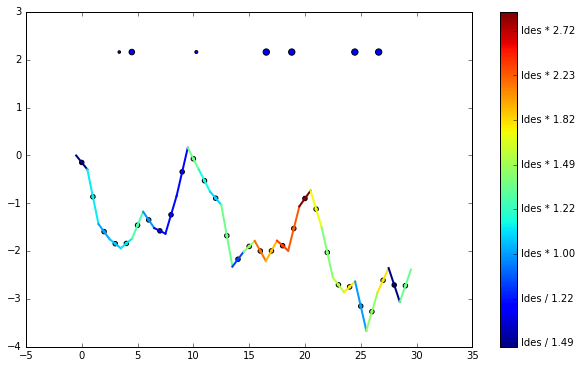

In [7]:
visualize_sol(p_rlsq)

### Constrained Least-square approximation (QP)

In [8]:
#variant 1
import picos as pic
P = pic.Problem()

p = P.add_variable('p',M,lower=0,upper=pmax)
P.minimize(pic.norm(A*p-Ides)**2,verbose=False)

p_lsq = p.value

In [9]:
#variant 2
import picos as pic
P = pic.Problem()

p = P.add_variable('p',M)

#TODO
P.add_constraint(p >= 0)
P.add_constraint(p <= pmax)

#P.minimize(abs(A*p-Ides)**2,verbose=False)
P.set_objective('min',pic.norm(A*p-Ides)**2)
P.solve(verbose=False)
#TODOend

p_lsq = p.value

[ 3.22e-01]
[ 1.52e+00]
[ 4.77e-01]
[ 1.81e+00]
[ 2.21e-07]
[ 1.97e-07]
[ 5.62e-01]
[ 3.30e-07]
[ 6.25e-01]
[ 2.00e+00]

des. Intensity: 0.1
min  Intensity: 0.0617746798074
max  Intensity: 0.132065763952
ratio Imax/Ides:1.32065763952
ratio Ides/Imin:1.61878621325


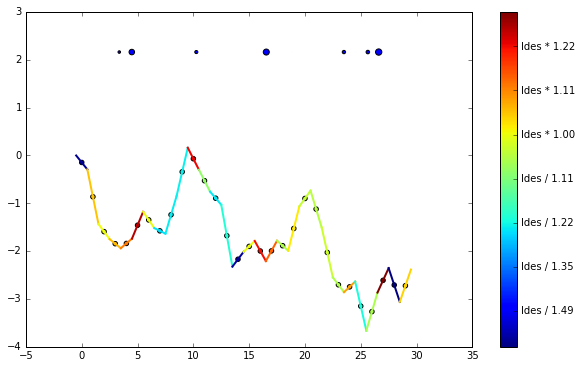

In [10]:
print p_lsq
visualize_sol(p_lsq)

### $L_\infty$-approximation (LP)

In [11]:
#variant 1
import picos as pic
P = pic.Problem()
p = P.add_variable('p',M)

#TODO 
P.add_constraint(p >= 0)
P.add_constraint(p <= pmax)
t = P.add_variable('t',1)
P.add_constraint(pic.norm(A*p-Ides,np.inf) <= t)
P.minimize(t,verbose=False)
#TODOend

p_linf = p.value

In [12]:
#variant 2
import picos as pic
P = pic.Problem()
p = P.add_variable('p',M)

#TODO 
P.add_constraint(p >= 0)
P.add_constraint(p <= pmax)
t = P.add_variable('t',1)
P.add_constraint(A*p-Ides <= t)
P.add_constraint(A*p-Ides >= -t)
P.minimize(t,verbose=False)
#TODOend

p_linf = p.value

des. Intensity: 0.1
min  Intensity: 0.0661976334197
max  Intensity: 0.133802366573
ratio Imax/Ides:1.33802366573
ratio Ides/Imin:1.51062802149


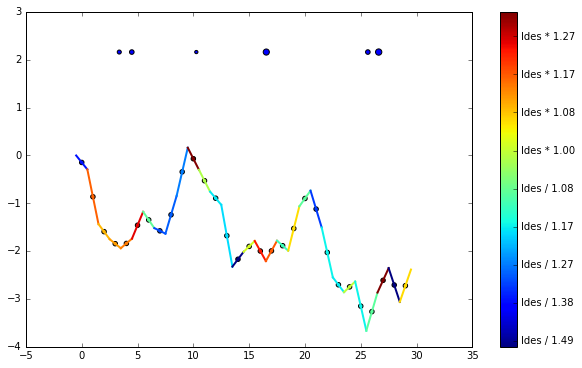

In [13]:
visualize_sol(p_linf)

### Convex-Programming solution

In [14]:
import picos as pic
P = pic.Problem()
p = P.add_variable('p',M)
I = A*p

#TODO
P.add_constraint(p >= 0)
P.add_constraint(p <= pmax)
u = P.add_variable('u',1)
for k in range(N):
    P.add_constraint(I[k] <= u * Ides)
    P.add_constraint(Ides <= u * I[k])
    
P.minimize(u,verbose=False)
#TODOend

p_cvx = p.value

des. Intensity: 0.1
min  Intensity: 0.0698485115999
max  Intensity: 0.143166973353
ratio Imax/Ides:1.43166973353
ratio Ides/Imin:1.43166973368


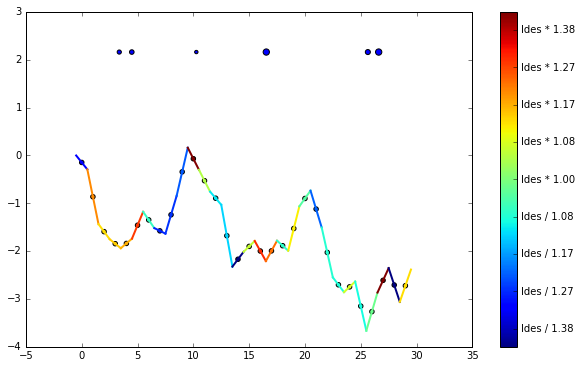

In [15]:
visualize_sol(p_cvx)

### LP solution + bisection

In [16]:
import picos as pic



alpha_lo = 1
alpha_up = 10

alpha = (alpha_lo+alpha_up)/2.

while alpha_up-alpha_lo > 0.0001:
    P = pic.Problem()
    p = P.add_variable('p',M)
    L = P.add_variable('L',1)
    U = P.add_variable('U',1)

    #TODO
    I = A*p
    P.add_constraint( p >= 0 )
    P.add_constraint( p <= pmax )
    P.add_constraint( I <= U )
    P.add_constraint( I >= L )
    
    
    P.add_constraint( alpha*L >= Ides )
    P.add_constraint( U <= alpha*Ides )
    
    P.minimize( 1|p, verbose=False )
    #TODOend
    
    if P.status == 'optimal':
        alpha_up = alpha
        p_lpb = p.value
    else:
        alpha_lo = alpha
        
    alpha = (alpha_lo+alpha_up)/2.
    print alpha_lo,alpha_up  

1 5.5
1 3.25
1 2.125
1 1.5625
1.28125 1.5625
1.421875 1.5625
1.421875 1.4921875
1.421875 1.45703125
1.421875 1.439453125
1.4306640625 1.439453125
1.4306640625 1.43505859375
1.4306640625 1.43286132812
1.4306640625 1.43176269531
1.43121337891 1.43176269531
1.43148803711 1.43176269531
1.43162536621 1.43176269531
1.43162536621 1.43169403076


des. Intensity: 0.1
min  Intensity: 0.0698473261772
max  Intensity: 0.143169402879
ratio Imax/Ides:1.43169402879
ratio Ides/Imin:1.43169403144


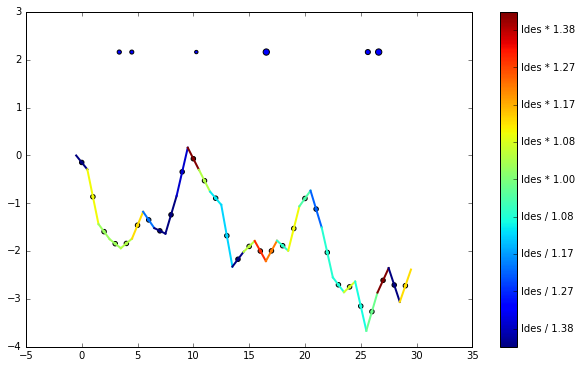

In [17]:
visualize_sol(p_lpb)